<a href="https://colab.research.google.com/github/Daviunb6202/Projetos-CIS-UnB/blob/main/Projeto_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise:

## Pré-processamento:
  Por meio do Sklearn, consegui normalizar, lemmantizar, tokenizar e vetorizar os textos em formato "Panda Series", mas ainda sim, o gradiente explodiu após 8 horas rodando no primeiro modelo RNN! Então tentei pelo Keras.Tensorflow, em que finalmente consegui este formato que criasse o dataset sem formato de tupla. 
  A única observação é que toda essa pipeline foi adaptada com base numa solução vinda de uma função já movida para um módulo de "desuso" do keras. Por conta disso, não consegui realizar o cálculo de frequência de palavra no texto (tf_idf), visto que esse é um argumento do método "text_to_sequences()", e este método não roda nos tensores/datasets construídos 

## Modelo 1 - RNN Simples 
O modelo foi composto de duas camadas de RNN simples e contou com quase 80 de acurácia de teste e quase 70 de acurácia na validação. Entender o funcionamento da camada de embedding e seu formato de input foi um desafio nessa fase. Assim como nos outros dois modelos seguintes, não foi possível utilizar os métodos predict() ou evaluate() junto com o score() do sklearn, devido a impossibilidade de extrair as labels do dataset em si.

## Modelo 2 - LSTM Unidirecional

Apesar de ter um nível de complexidade maior, a célula LSTM performou um pouco pior na parte de treinamento.

## Modelo 3 - LSTM Bidirecional 
Com 75 de acurácia no treinamento, e 70 na validação, o resultado foi levemente abaixo do esperado.

## Modelo Support Vector Machine linear via Sklearn 
 
Para que fosse possível usar este  modelo sklearn, foi necessário utilizar uma outra pipeline de préprocessamento, em que foi possível utilizar o método tf_idf de frequência de palavras(o que provavelmente pesou no resultado). Com resultado muito parecido com o primeiro modelo, obteve uma acurácia de quase 80%.

In [ ]:
 from google.colab import drive

In [ ]:
!pip install --user tensorflow-addons

In [ ]:
!pip install --user tensorflow --upgrade --force-reinstall

In [ ]:
pip install --upgrade tensorflow-gpu

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 2.8 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=f73575b865ea2020bdeec10bdad82de8558aeda5a5051871ccbc64202facf6b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rxvd0_um/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
!pip install tensorflow_transform

In [270]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
import sklearn as sk  
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

## Importação

In [271]:
df = pd.read_csv("/content/drive/MyDrive/Musical_instruments_reviews.csv")
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True)
df.isna().sum()

index             0
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

## Pré-processamento 

In [272]:
df['overall'] = pd.Categorical(df['overall'])
df['overall'] = df.overall.cat.codes
#df['overall'] = [1 if text>5 else 0 for text in df['overall'] ] #Aqui achei que fez mais sentido separar o texto em bom ou ruim,
                                                               #pelo menos em um primeiro momento 
target = df.pop('overall')
df = df['reviewText']

## Segundo problema, não sei exatamente como codar essa dimensão dos time steps ! 

In [273]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(df, target, train_size=0.5, random_state=42)

## Problema de Dataset.from_tensor_slices() por meio de tuplas e não consegue rodar em outras funções 

In [274]:
X_train = tf.constant(X_train)                 #Tranformando em tensor 
y_train = tf.constant(y_train, dtype= tf.int32)
X_valid = tf.constant(X_valid)
y_valid = tf.constant(y_valid, dtype= tf.int32)
X_test = tf.constant(X_test)
y_test = tf.constant(y_test, dtype= tf.int32)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))  #Formando datasets
dataset_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [275]:
for df, target in dataset_train.take(1):
  print(df, target)

tf.Tensor(b"This is a pretty good deal if you look at the price of other capos, and you get free shipping.Yeah, it's not as quick to use as the spring loaded ones, but still not bad; better than an elastic strap type.It is also great for creating your own short cut and drop D capos.  With a sharp razor you could do all sorts of crazy stuff.Do not overtighten the screw because the bottom arm is thin. You can add a pad of some sort, or just take care to not to over-tighten it.I'm the type of person that would glue in a small piece of material if it broke through.  So, far it doesn't look like it will though.", shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=int32)


In [276]:
from collections import Counter 
import tensorflow_datasets as tfds

vocab_size = 10000
tk = tfds.deprecated.text.Tokenizer()
#for df,target in dataset:

lowercase = True  # set this to `False` if case-sensitivity is important.
vocabulary = Counter()
for text, target in dataset_train:
    if lowercase:
       text = tf.strings.lower(text)  #Deixa todos os caractéres minúsculos
    tokens = tk.tokenize(text.numpy())  #Tokenize vai separar os temors das strings em tokens, só que antes o argumento text vai de tensor para numpy array
    vocabulary.update(tokens)      

vocabulary, _ = zip(*vocabulary.most_common(vocab_size))

print(vocabulary)

encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary, #Transforma palavras(tokens) em números inteiros
                                              lowercase=lowercase,
                                              oov_buckets = round(len(vocabulary)*0.1),
                                              tokenizer=tk)

max_len = 100


def encode(text, target):
    text_encoded = encoder.encode(text.numpy())
    if max_len:
        text_encoded = text_encoded[:max_len] #Limite máximo de tokens por frase
    return text_encoded, target


def encode_pyfn(text, target):
  text_encoded, target = tf.py_function(encode,     #py_function foi finalmente a forma encontrada de rodar uma função no modo Eager do tensor
                                          inp=[text, target],
                                          Tout=(tf.int32, tf.int32)) #tout = type of output 
  return text_encoded, target




('the', 'i', 'a', 'and', 'it', 'to', 'is', 'of', 'for', 'this', 'you', 'that', 'on', 'my', 'with', 'in', 'but', 'have', 's', 't', 'are', 'not', 'as', 'guitar', 'they', 'so', 'one', 'these', 'if', 'or', 'can', 'great', 'like', 'be', 'was', 'very', 'good', 'just', 'use', 'sound', 'all', 'strings', 'well', 'at', 'more', 'your', 'out', 'an', 'up', 'will', 'them', 'when', 'get', 'from', 'pedal', 'than', 'no', 'has', 'would', 'me', 'really', 'what', 'other', 'price', 'some', 'do', 'amp', 'little', 'about', 'there', 've', 'had', 'don', 'much', 'works', 'only', 'quality', 'also', 'nice', 'which', 'used', 'better', 'm', 'any', 'does', 'time', 'tone', 'too', 'easy', 'because', 'using', 'bought', 'stand', 'even', 'need', 'play', 'mic', 'strap', 'by', 'string', 'picks', 'work', 'its', 'buy', 'off', 'playing', 'guitars', 'over', 'now', 'been', 'into', 'way', 're', 'want', 'am', 'tuner', 'made', 'd', 'product', '34', 'after', 'still', 'pedals', 'got', 'cable', 'thing', 'right', 'sounds', 'acoustic',

In [277]:
for r in dataset_train.take(1):
  print(r)
 #agora os textos foram codificados em números ! 

(<tf.Tensor: shape=(), dtype=string, numpy=b"This is a pretty good deal if you look at the price of other capos, and you get free shipping.Yeah, it's not as quick to use as the spring loaded ones, but still not bad; better than an elastic strap type.It is also great for creating your own short cut and drop D capos.  With a sharp razor you could do all sorts of crazy stuff.Do not overtighten the screw because the bottom arm is thin. You can add a pad of some sort, or just take care to not to over-tighten it.I'm the type of person that would glue in a small piece of material if it broke through.  So, far it doesn't look like it will though.">, <tf.Tensor: shape=(), dtype=int32, numpy=4>)


In [278]:
  
dataset_train = dataset_train.map(encode_pyfn).padded_batch(batch_size=300, drop_remainder=True,#ao msm tempo que ocorre o padding (tokens não existentes igual a 0) ocorre a divisão em batches
                                                            padded_shapes=([None], [])).prefetch(1) #prefetch para acelerar os cálculos

dataset_valid = dataset_valid.map(encode_pyfn).padded_batch(batch_size=300, drop_remainder=True, #Drop remainder não forma batches menores em divisão imperfeita    
                                                padded_shapes=([None], [])).prefetch(1)  
   
dataset_test = dataset_test.map(encode_pyfn).padded_batch(batch_size=300, drop_remainder=True,
                                                padded_shapes=([None], [])).prefetch(1)        

In [279]:
dataset_train

<PrefetchDataset element_spec=(TensorSpec(shape=(300, None), dtype=tf.int32, name=None), TensorSpec(shape=(300,), dtype=tf.int32, name=None))>

## Modelo Simples RNN 


In [220]:
embed_size = 64
vocab_size = len(vocabulary)
num_oov_buckets = round(vocab_size*0.20)
model1 = keras.models.Sequential([
keras.layers.Embedding(input_dim=vocab_size + num_oov_buckets, output_dim= embed_size, input_shape=[None]),
keras.layers.SimpleRNN(64, return_sequences=True), #return sequences permite rodar outra camada de RNN 
keras.layers.SimpleRNN(32),
keras.layers.Dense(5, activation='softmax')
])


In [222]:
from tensorflow.keras.optimizers import Adam
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, min_delta=0.02, baseline=90.00, restore_best_weights=True) 


model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(dataset_train, validation_data= dataset_valid, epochs=20, callbacks=[early_stopping_cb])
model1.save('Modelo_simples_RNN.h5')

#o argumento "validation_split não funciona para tensorflow datasets ! "

Epoch 1/20
23/23 [==============================] - 14s 492ms/step - loss: 0.9454 - accuracy: 0.6788 - val_loss: 0.9293 - val_accuracy: 0.6831
Epoch 2/20
23/23 [==============================] - 11s 462ms/step - loss: 0.8688 - accuracy: 0.7190 - val_loss: 0.9136 - val_accuracy: 0.6818
Epoch 3/20
23/23 [==============================] - 11s 468ms/step - loss: 0.7545 - accuracy: 0.7530 - val_loss: 0.9456 - val_accuracy: 0.6804
Epoch 4/20
23/23 [==============================] - 10s 455ms/step - loss: 0.6690 - accuracy: 0.7839 - val_loss: 0.9239 - val_accuracy: 0.6953


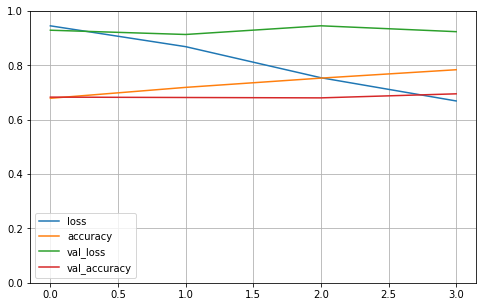

In [223]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

## LTSM Unidirecional 

In [224]:
model2 = keras.models.Sequential([
keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None]),                                                              
keras.layers.LSTM(64, return_sequences=True),
keras.layers.LSTM(32),
keras.layers.Dense(5, activation='softmax')
])

In [225]:
from tensorflow.keras.optimizers import Adam
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, min_delta=0.02, baseline=90.00, restore_best_weights=True) 


model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(dataset_train, validation_data= dataset_valid, epochs=20, callbacks=[early_stopping_cb])
model2.save('LSTM_unidirecional.h5')

Epoch 1/20
23/23 [==============================] - 76s 3s/step - loss: 1.2253 - accuracy: 0.6629 - val_loss: 0.9646 - val_accuracy: 0.6710
Epoch 2/20
23/23 [==============================] - 16s 697ms/step - loss: 0.9613 - accuracy: 0.6787 - val_loss: 0.9541 - val_accuracy: 0.6710
Epoch 3/20
23/23 [==============================] - 16s 690ms/step - loss: 0.9470 - accuracy: 0.6787 - val_loss: 0.9482 - val_accuracy: 0.6710
Epoch 4/20
23/23 [==============================] - 16s 688ms/step - loss: 0.9319 - accuracy: 0.6787 - val_loss: 0.9383 - val_accuracy: 0.6714
Epoch 5/20
23/23 [==============================] - 18s 798ms/step - loss: 0.8978 - accuracy: 0.6848 - val_loss: 0.9244 - val_accuracy: 0.6761
Epoch 6/20
23/23 [==============================] - 20s 876ms/step - loss: 0.8690 - accuracy: 0.7017 - val_loss: 0.9309 - val_accuracy: 0.6771
Epoch 7/20
23/23 [==============================] - 16s 698ms/step - loss: 0.8617 - accuracy: 0.7119 - val_loss: 0.9208 - val_accuracy: 0.6753


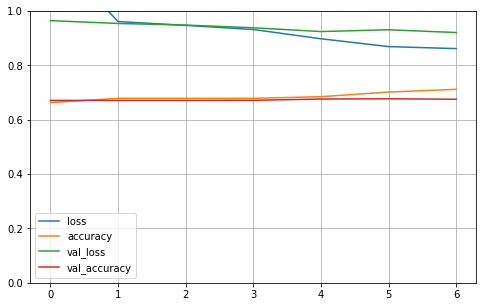

In [227]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

# LTSM Bidirecional 


In [294]:
model3 = keras.models.Sequential([
keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size),
keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(32)),
keras.layers.Dense(5)
])

In [293]:
from tensorflow.keras.optimizers import Adam
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, min_delta=0.02, baseline=90.00, restore_best_weights=True) 


model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(dataset_train, validation_data= dataset_valid, epochs=20, callbacks=[early_stopping_cb])
model3.save('Modelo_melhorado.h5')

Epoch 1/20
23/23 [==============================] - 17s 548ms/step - loss: 1.1997 - accuracy: 0.6883 - val_loss: 1.2234 - val_accuracy: 0.6767
Epoch 2/20
23/23 [==============================] - 15s 653ms/step - loss: 1.0728 - accuracy: 0.7138 - val_loss: 1.5396 - val_accuracy: 0.6945
Epoch 3/20
23/23 [==============================] - 12s 503ms/step - loss: 1.3307 - accuracy: 0.7577 - val_loss: 1.6510 - val_accuracy: 0.6922
Epoch 4/20
23/23 [==============================] - 12s 517ms/step - loss: 0.9923 - accuracy: 0.7528 - val_loss: 1.2999 - val_accuracy: 0.6931


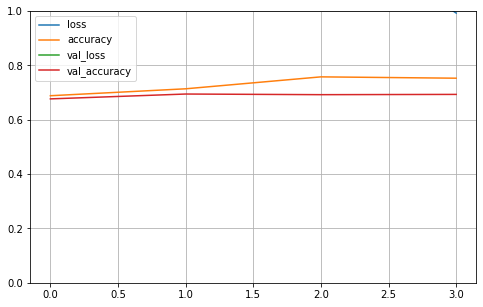

In [295]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

## Meios de comparação no sklearn

In [258]:
df = pd.read_csv("/content/drive/MyDrive/Musical_instruments_reviews.csv")
df = pd.DataFrame(df)
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True)
df.isna().sum()

index             0
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [259]:
df['overall'] = pd.Categorical(df['overall'])
df['overall'] = df.overall.cat.codes

target = df.pop('overall')
df = df['reviewText']

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(df, target, train_size=0.5, random_state=42)

In [261]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")


from nltk import word_tokenize
from nltk.corpus import stopwords
import re
def Prep(text):
  text.lower()         #normaliza tudo para minúsculas
  text = re.sub(r"[^\w\s]", " ", text) #padrão ReGeX em que seja tudo menos(^) palavras(\w) e espaços (\s)
  text = re.sub(r"[\s\s]", " ", text) #substituindo dois espaços por um só
  text = re.split('\s+', text) #Pré tokenização separando termos por espaços entre eles
  stemmer = PorterStemmer()
  words = []
  for i in text: 
    words.append(word_tokenize(i))  #Finalmente quebra os termos em tokens 
  stemmed_words = []
  en_stopwords =  stopwords.words('english') #importando stopwords(artigos,interjeições,preposições)
  for word in words:
    for i in word:
      if i not in en_stopwords:          
        stemmed_words.append(stemmer.stem(i))       #se não for é adicionado 
  return  " ".join(str(np.array(stemmed_words)).split()) #Une tudo por espaços 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [262]:
for i in range(len(df)):
    result = Prep(df[i])
    df[i] = result

In [263]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
                                     #Une o Tfidf com o a função CountVectorizer (Bag of words)
                                     #fazendo então a vetorização com um processo de balancear as ocorrências das palavras(e por conseguinte os pesos)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_valid, X_test =  vectorizer.transform(X_valid), vectorizer.transform(X_test)

In [264]:
from sklearn import svm
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X=X_train, y=y_train)

SVC(kernel='linear')

In [265]:
predicao = clf_svm.predict(X_test) 

sk.metrics.mean_squared_error(y_test, predicao)

0.7107373362018384

In [266]:
clf_svm.score(X_test, y_test)

0.7787991394484647